In [1]:
import os, glob, shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
from models2 import Net
%matplotlib inline

In [2]:
# Initiazlie net
net = Net()

# load previously trained net
net.load_state_dict(torch.load('saved_models/keypoints_models2_1.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=2048, bias=True)
  (fc1_bn): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc2_bn): BatchNorm1d(512, eps=1e

# Best fit picker
After loading a model it's time to test it on LFW [dataset](http://vis-www.cs.umass.edu/lfw/). Best predictions are presented below.

In [3]:
def show_all_keypoints(image, keypoints):
    """
    Visuzlizing the image and the keypoints on it.
    """
    plt.figure(figsize=(5,5))

    keypoints = keypoints.data.numpy()
    keypoints = keypoints *50.0 +100 # Becuase of normalization, keypoints won't be placed if they won't reutrn to values before noramlization 
    keypoints = np.reshape(keypoints, (68, -1)) # reshape to 2 X 68 keypoint for the fase

    image = image.numpy()   
    image = np.transpose(image, (1, 2, 0))  # Convert to numpy image shape (H x W x C)
    image = np.squeeze(image)
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=40, marker='.', c='m')
    plt.show(block=False)
    
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('saved_models/haarcascade_frontalface_default.xml')

# create list of paths of test images
PATHS = []
for filename in glob.iglob('faces_photos//**', recursive=True):
    if os.path.isfile(filename): # filter dirs
        PATHS.append(filename)
print(len(PATHS), PATHS[0:5])

86 ['faces_photos/Ali_Ahmeti_0001.jpg', 'faces_photos/Alec_Baldwin_0001.jpg', 'faces_photos/Arnold_Schwarzenegger_0024.jpg', 'faces_photos/AJ_Lamas_0001.jpg', 'faces_photos/Angelina_Jolie_0019.jpg']


In [4]:
def predict_keypoints(paths, HaarCascade):
    for path in paths:
        image = cv2.imread(path)
        # switch red and blue color channels 
        # --> by default OpenCV assumes BLUE comes first, not RED as in many images
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Haar cascade
        faces = HaarCascade.detectMultiScale(image,1.3, 5)
        image_copy = np.copy(image)

        # show kepoints
        for (x,y,w,h) in faces:
            
            # Select the region of interest that is the face in the image 
            # I found that modifing values here https://github.com/soheillll/Facial-Keypoint-Detection/blob/master/3.%20Facial%20Keypoint%20Detection%2C%20Complete%20Pipeline.ipynb
            roi = image_copy[y:y + int(1.5 * h), x - int(0.4 * w):x + int(1.1 * w)]
            
            # Convert from RGB to GRAYSCALE
            roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
            
            # Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
            roi = roi / 255.0

            # Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
            roi = cv2.resize(roi, (224, 224))

            # Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
            roi = np.expand_dims(roi, 0)
            roi = np.expand_dims(roi, 0) # (1, 1, 224, 224)

            # Make facial keypoint predictions using your loaded, trained network 
            # Converting numpy to torch tensor
            roi_torch = torch.from_numpy(roi) 
            roi_torch = roi_torch.type(torch.FloatTensor)
            # Forward pass
            keypoints = net(roi_torch) 

            # Display each detected face and the corresponding keypoints        
            show_all_keypoints(roi_torch.squeeze(0), keypoints)
            print(path)

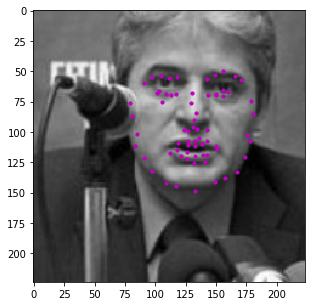

faces_photos/Ali_Ahmeti_0001.jpg


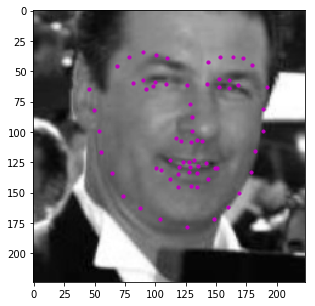

faces_photos/Alec_Baldwin_0001.jpg


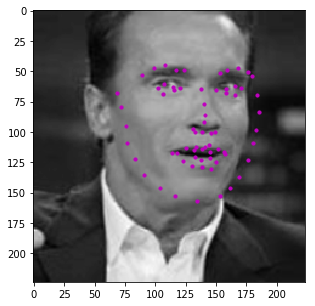

faces_photos/Arnold_Schwarzenegger_0024.jpg


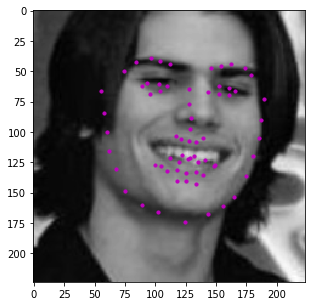

faces_photos/AJ_Lamas_0001.jpg


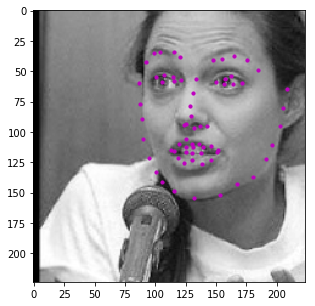

faces_photos/Angelina_Jolie_0019.jpg


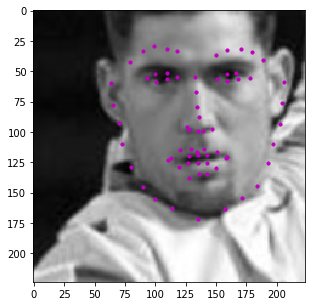

faces_photos/Alex_Cabrera_0001.jpg


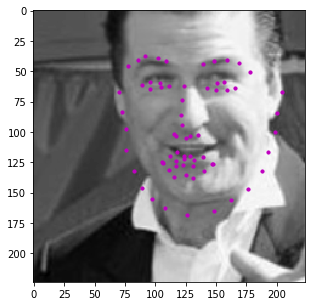

faces_photos/Alec_Baldwin_0002.jpg


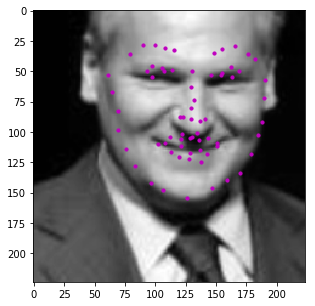

faces_photos/Aleksander_Kwasniewski_0002.jpg


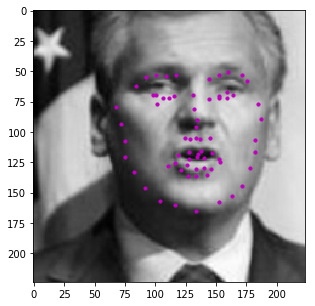

faces_photos/Aleksander_Kwasniewski_0003.jpg


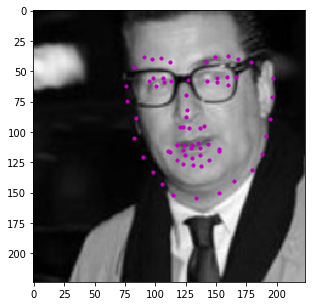

faces_photos/Alec_Baldwin_0003.jpg


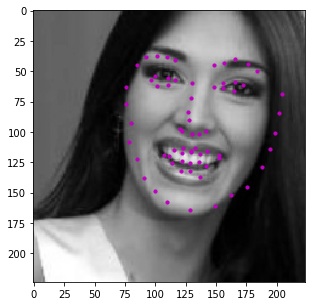

faces_photos/Amelia_Vega_0007.jpg


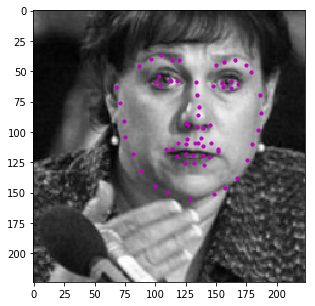

faces_photos/Ann_Veneman_0002.jpg


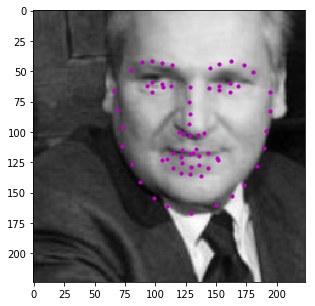

faces_photos/Aleksander_Kwasniewski_0004.jpg


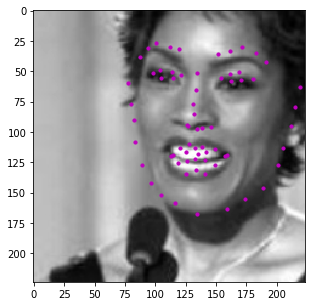

faces_photos/Angela_Bassett_0004.jpg


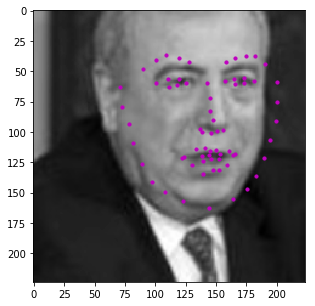

faces_photos/Alexander_Rumyantsev_0002.jpg


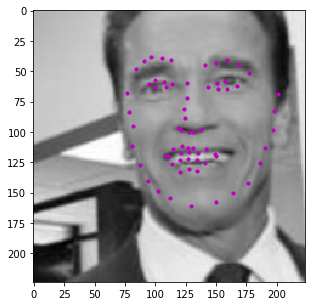

faces_photos/Arnold_Schwarzenegger_0035.jpg


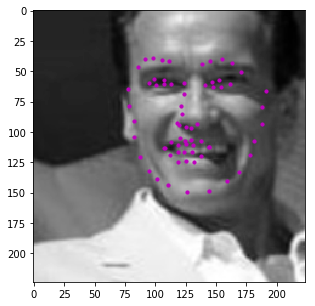

faces_photos/Arnold_Schwarzenegger_0009.jpg


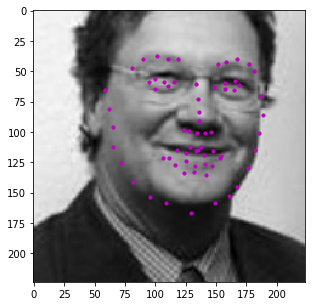

faces_photos/Alexander_Downer_0003.jpg


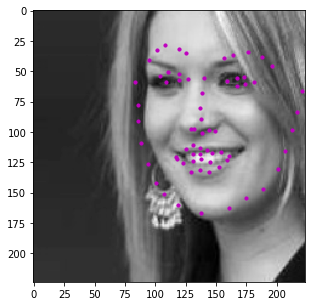

faces_photos/Ashlea_Talbot_0001.jpg


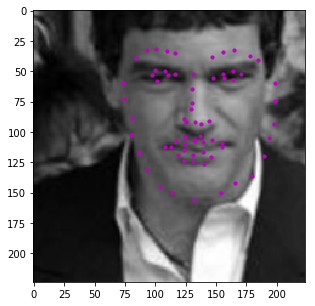

faces_photos/Antonio_Banderas_0003.jpg


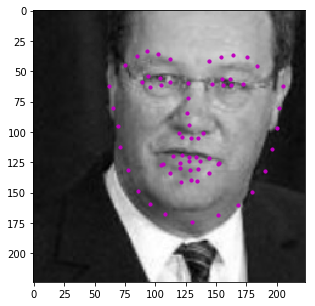

faces_photos/Alexander_Downer_0002.jpg


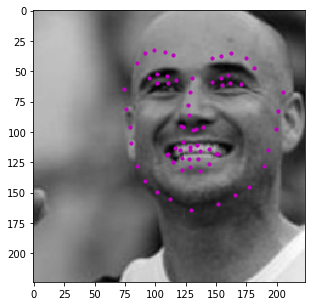

faces_photos/Andre_Agassi_0029.jpg


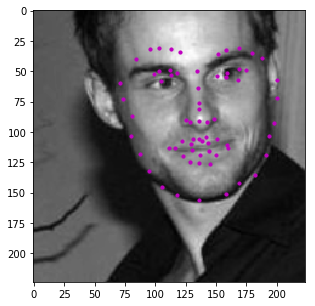

faces_photos/Andy_Roddick_0013.jpg


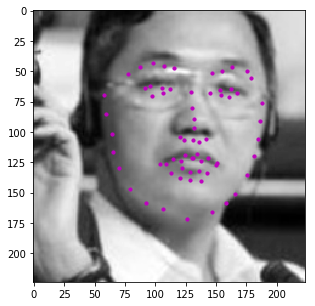

faces_photos/Adisai_Bodharamik_0001.jpg


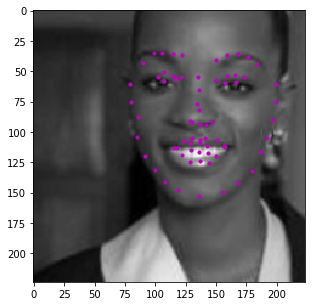

faces_photos/Ana_Sebastiao_0001.jpg


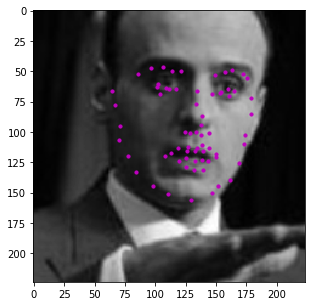

faces_photos/Adel_Al-Jubeir_0002.jpg


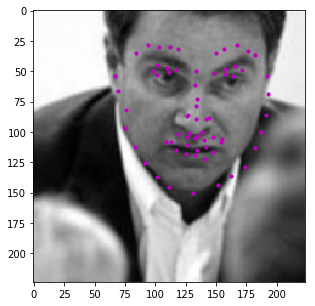

faces_photos/Andrew_Luster_0001.jpg


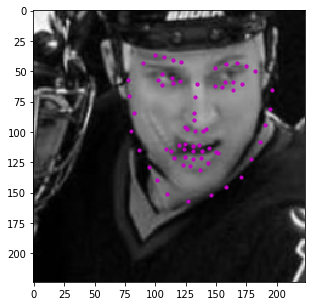

faces_photos/Adam_Mair_0001.jpg


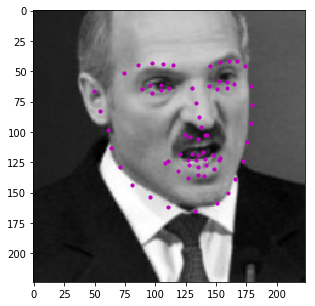

faces_photos/Alexander_Lukashenko_0001.jpg


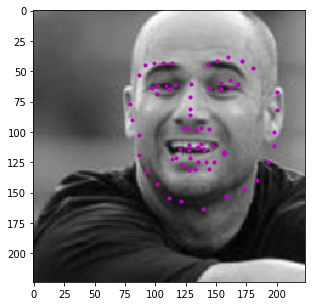

faces_photos/Andre_Agassi_0016.jpg


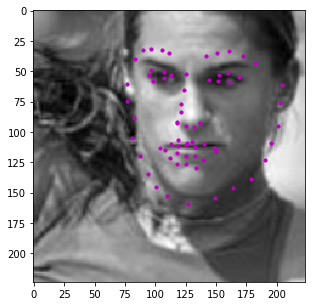

faces_photos/Amelie_Mauresmo_0007.jpg


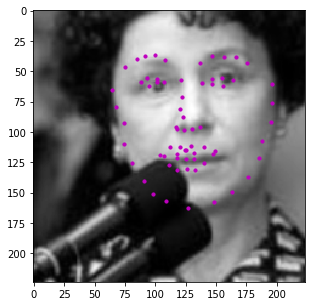

faces_photos/Ana_Palacio_0004.jpg


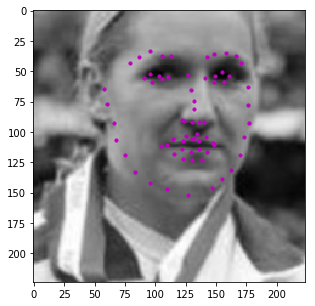

faces_photos/Anastasia_Kelesidou_0001.jpg


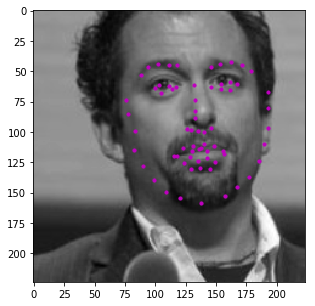

faces_photos/Andrew_Jarecki_0001.jpg


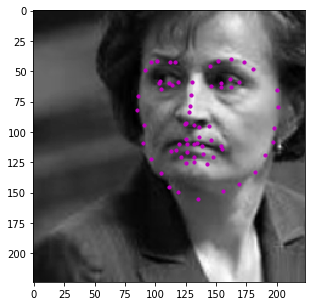

faces_photos/Anneli_Jaatteenmaki_0001.jpg


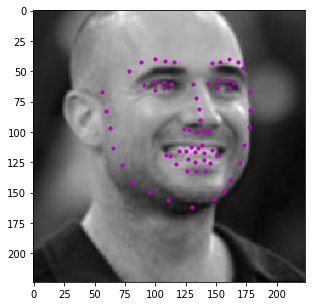

faces_photos/Andre_Agassi_0007.jpg


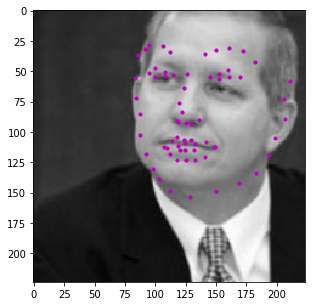

faces_photos/Alex_Popov_0001.jpg


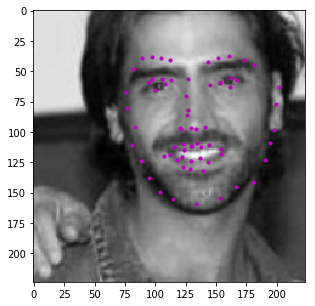

faces_photos/Alejandro_Fernandez_0001.jpg


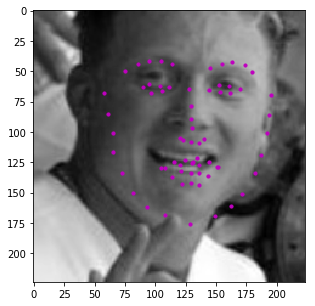

faces_photos/Aaron_Guiel_0001.jpg


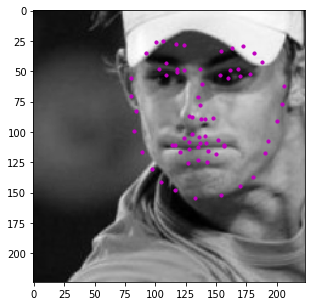

faces_photos/Andy_Roddick_0014.jpg


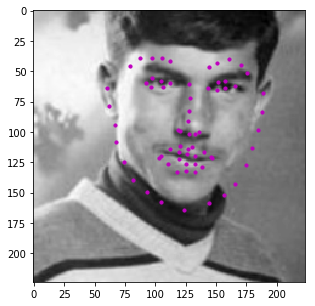

faces_photos/Abdel_Madi_Shabneh_0001.jpg


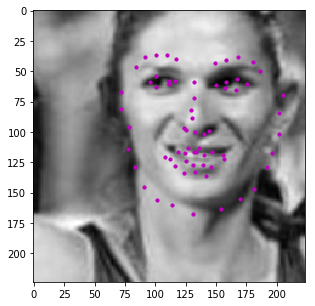

faces_photos/Ana_Guevara_0006.jpg


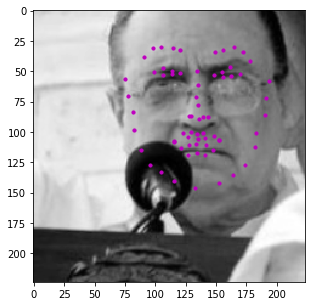

faces_photos/Abel_Pacheco_0004.jpg


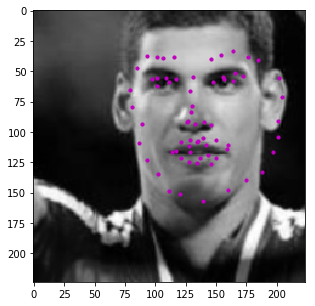

faces_photos/Ahmed_Lopez_0001.jpg


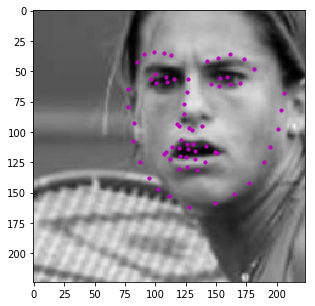

faces_photos/Amelie_Mauresmo_0009.jpg


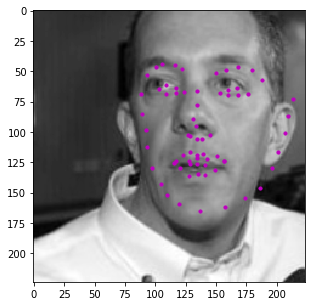

faces_photos/Andy_Graves_0001.jpg


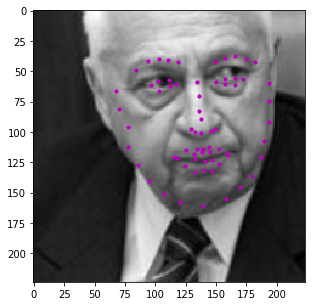

faces_photos/Ariel_Sharon_0039.jpg


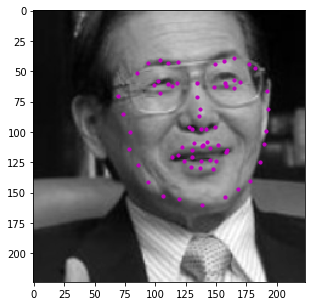

faces_photos/Alberto_Fujimori_0001.jpg


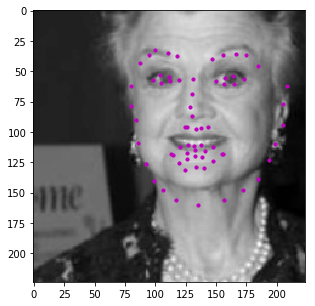

faces_photos/Angela_Lansbury_0001.jpg


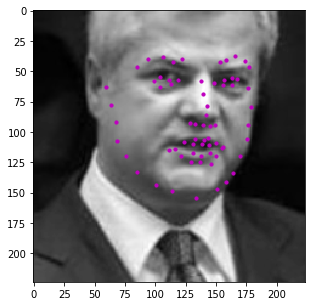

faces_photos/Adrian_Nastase_0001.jpg


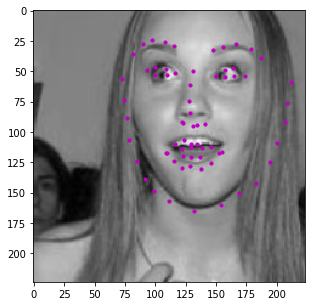

faces_photos/Amanda_Bynes_0002.jpg


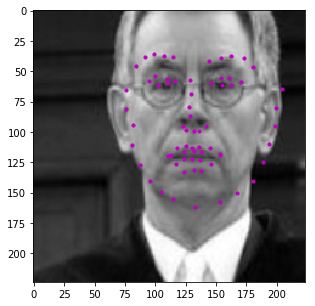

faces_photos/Albrecht_Mentz_0002.jpg


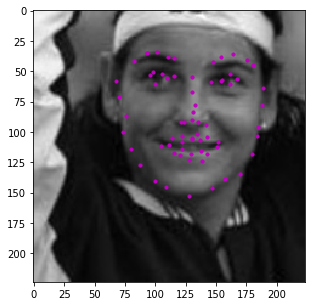

faces_photos/Arantxa_Sanchez-Vicario_0002.jpg


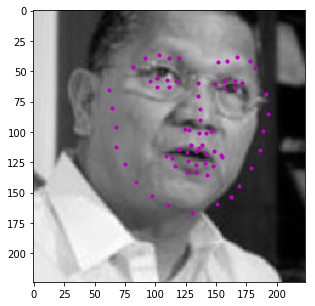

faces_photos/Angelo_Reyes_0004.jpg


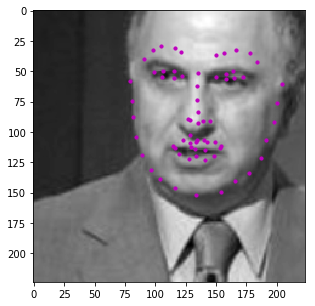

faces_photos/Ahmed_Chalabi_0003.jpg


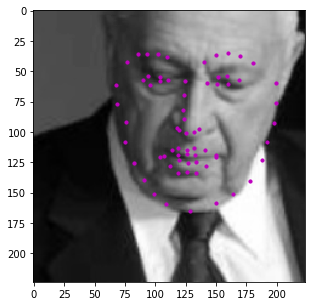

faces_photos/Ariel_Sharon_0029.jpg


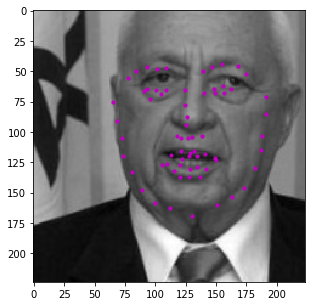

faces_photos/Ariel_Sharon_0015.jpg


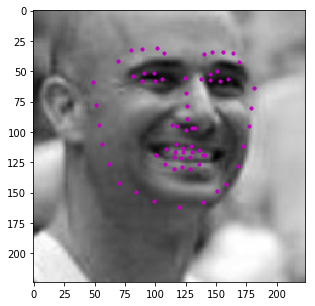

faces_photos/Andre_Agassi_0024.jpg


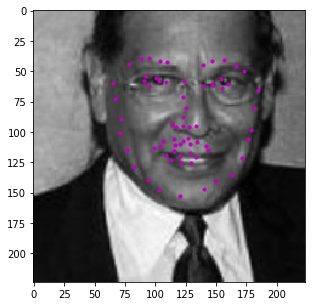

faces_photos/Anthony_Pico_0001.jpg


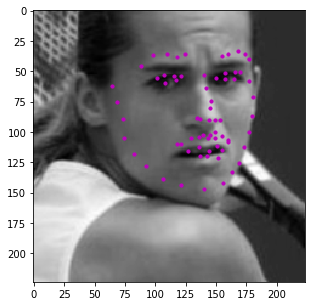

faces_photos/Amelie_Mauresmo_0019.jpg


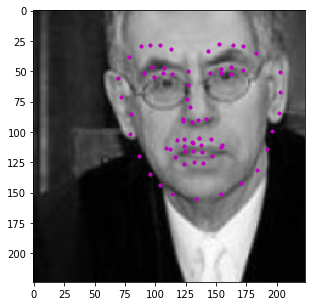

faces_photos/Albrecht_Mentz_0001.jpg


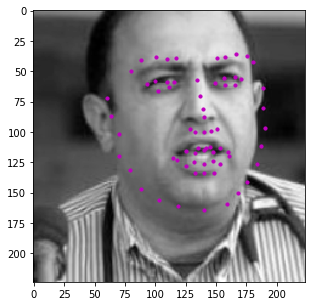

faces_photos/Andy_Madikians_0001.jpg


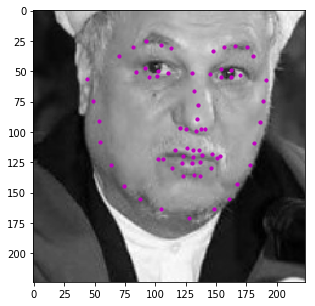

faces_photos/Akbar_Hashemi_Rafsanjani_0001.jpg


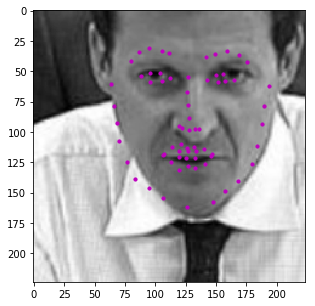

faces_photos/Alastair_Campbell_0001.jpg


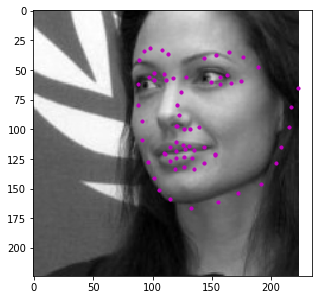

faces_photos/Angelina_Jolie_0013.jpg


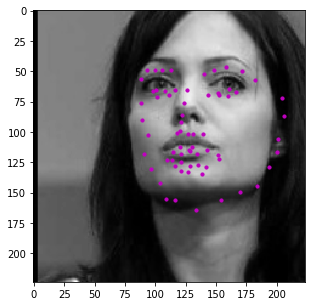

faces_photos/Angelina_Jolie_0007.jpg


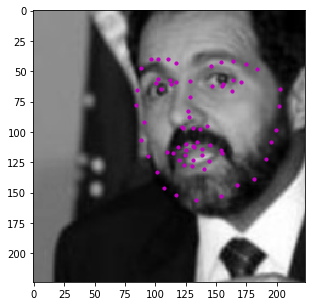

faces_photos/Agnelo_Queiroz_0001.jpg


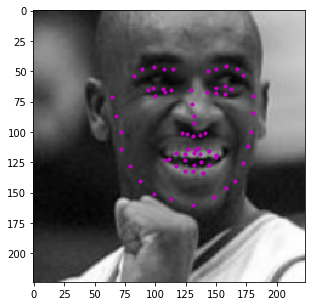

faces_photos/Andre_Smith_0001.jpg


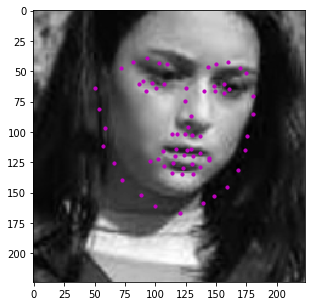

faces_photos/Alexa_Vega_0001.jpg


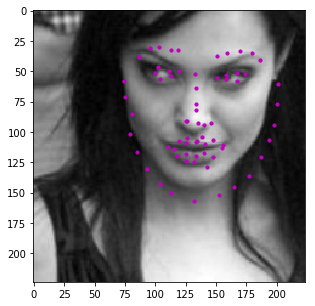

faces_photos/Angelina_Jolie_0010.jpg


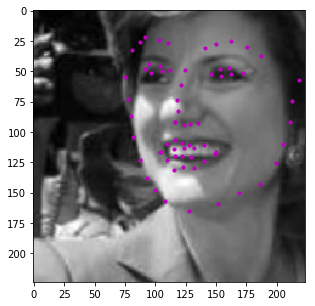

faces_photos/Arianna_Huffington_0001.jpg


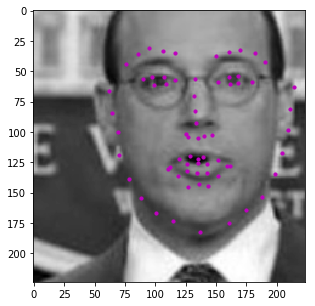

faces_photos/Ari_Fleischer_0007.jpg


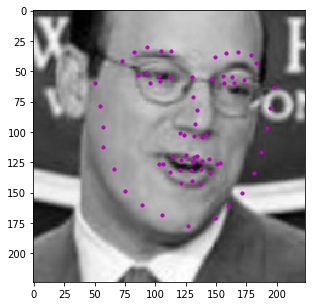

faces_photos/Ari_Fleischer_0013.jpg


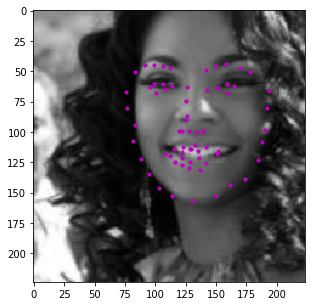

faces_photos/Ashanti_0003.jpg


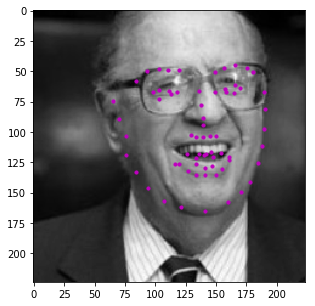

faces_photos/Abba_Eban_0001.jpg


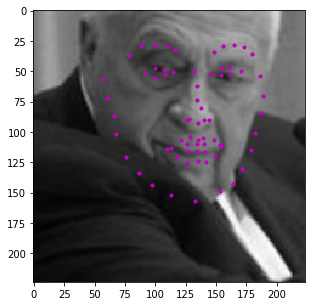

faces_photos/Ariel_Sharon_0067.jpg


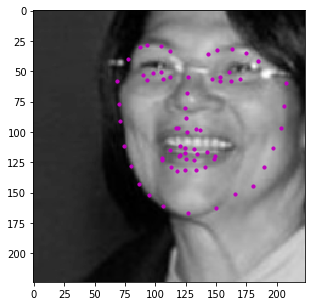

faces_photos/Anita_DeFrantz_0001.jpg


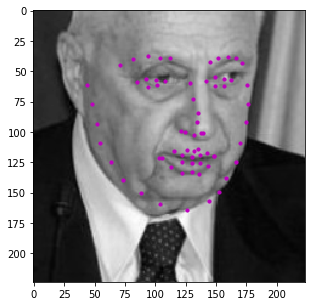

faces_photos/Ariel_Sharon_0063.jpg


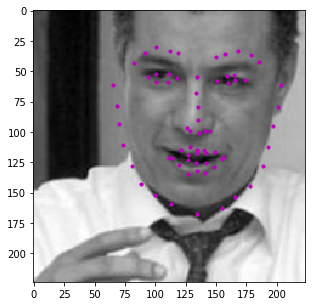

faces_photos/Angel_Lockward_0001.jpg


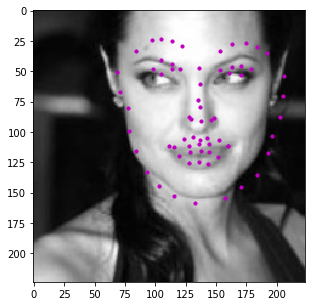

faces_photos/Angelina_Jolie_0015.jpg


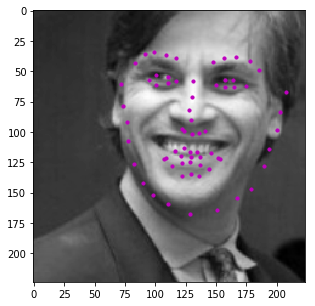

faces_photos/Aaron_Sorkin_0002.jpg


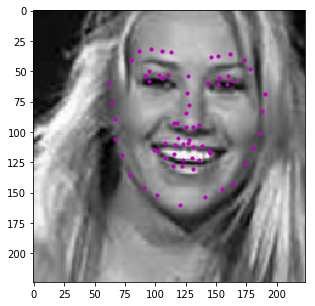

faces_photos/Anna_Kournikova_0012.jpg


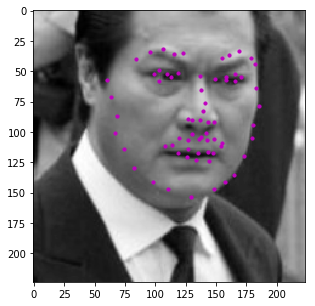

faces_photos/Alan_Tang_Kwong-wing_0001.jpg


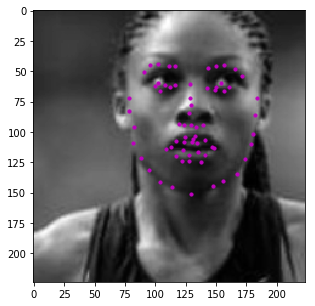

faces_photos/Allyson_Felix_0005.jpg


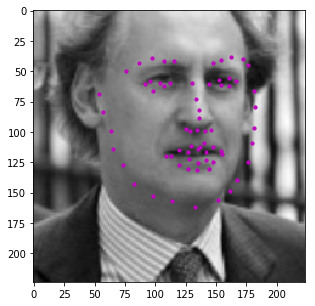

faces_photos/Andrew_Caldecott_0001.jpg


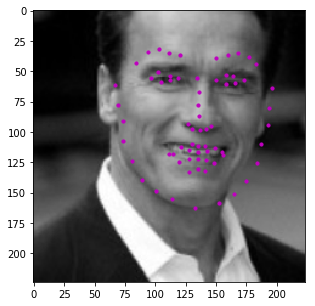

faces_photos/Arnold_Schwarzenegger_0014.jpg


In [5]:
predict_keypoints(PATHS, face_cascade)